In [28]:
import pandas as pd
import itertools
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pmdarima as pm
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.stattools import adfuller

In [2]:
data = pd.read_csv('../data\circuit_flight\dense_flights_data.csv')
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK',
       'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED',
       'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY', 'ORIGIN_AIRPORT_IATA', 'DESTINATION_AIRPORT_IATA',
       'Date', 'SD', 'DT', 'WF', 'WN', 'SA', 'AT', 'FLIGHT_ID'],
      dtype='object')

In [37]:
class pipline:
    def __init__(self,flights,is_iqr,is_boxcox,train_ratio=0.8):
        self.flights = flights
        self.is_iqr = is_iqr,
        self.is_boxcox = is_boxcox 
        self.train_ratio = train_ratio

    def IQR(self,y):
        Q3 = y.quantile(0.75)
        Q1 = y.quantile(0.25)
        IQR = Q3-Q1
        lower_bound = Q1 - IQR*1.5
        upper_bound = Q3 + IQR*1.5

        y[(y > upper_bound).values | (y<lower_bound).values] = np.nan
        y = y.interpolate(method='linear') 
        return y
    
    def box_cox(self,y):
        y_min = np.min(y)-0.1
        y_box, lbd = boxcox(y.values.ravel()-y_min)  
        self.lbd = lbd
        self.y_min = y_min
        return y_box
    
    def fit(self):
        y_raw = self.flights.iloc[:int(np.floor(self.flights.shape[0]*self.train_ratio)),:].loc[:,['ARRIVAL_DELAY','SD']].set_index('SD').interpolate(method='linear')
        y_test = self.flights.iloc[int(np.floor(self.flights.shape[0]*self.train_ratio)):,:].loc[:,['ARRIVAL_DELAY','SD']].set_index('SD').interpolate(method='linear')

        if self.is_iqr:
            y_iqr = self.IQR(y_raw)
        else:
            y_iqr = y_raw

        if self.is_boxcox:
            y_box = self.box_cox(y_iqr)
        else:
            y_box = y_iqr

        y_box = pd.Series(y_box)
        self.y_box = y_box

        model = pm.auto_arima(y_box, seasonal=True, trace=False)
        self.model = model

        y_pred = []
        for i in range(len(y_test)):
            forecast = model.predict_in_sample(X=y_box, start=len(y_box)-len(y_test)+i, end=len(y_box)-len(y_test)+i)
            y_pred.append(forecast.iloc[0])

        y_pred = np.array(y_pred)

        if self.is_boxcox:
            # 对预测值进行box-cox逆变换
            y_pred = inv_boxcox(y_pred, self.lbd) + self.y_min

        self.y_test = y_test
        self.y_pred = y_pred

    def metrics(self):
        rmse = np.sqrt(mean_squared_error(self.y_test, self.y_pred))
        print(f"RMSE: {rmse:.3f}")

        # 计算MAE
        mae = mean_absolute_error(self.y_test, self.y_pred)
        print(f"MAE: {mae:.3f}")

        # 计算MAPE
        mape = mean_absolute_percentage_error(self.y_test, self.y_pred)
        print(f"MAPE: {mape:.3%}")

    def summary(self):
        print(self.model.summary())

        # 计算训练数据的残差
        y_train_pred = self.model.predict_in_sample(X=self.y_box)
        residuals_train = self.y_box - y_train_pred

        # 绘制训练数据残差的ACF图
        fig, ax = plt.subplots(figsize=(10, 6))
        sm.graphics.tsa.plot_acf(residuals_train, lags=20, ax=ax)
        ax.set_title('Training Data Residual ACF')
        ax.set_xlabel('Lag')
        ax.set_ylabel('Autocorrelation')
        plt.show()

    def plot(self):
        # 绘制实际值和预测值
        plt.figure(figsize=(12, 6))
        plt.plot(self.y_test.values, label='Actual')
        plt.plot(self.y_pred, label='Predicted')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Actual vs. Predicted Values')
        plt.legend()
        plt.show()

    def ACF(self):
        # 设置2行3列的子图布局
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

        # 原始数据
        tsa_plots.plot_acf(self.y_box, lags=40, ax=axes[0, 0])
        axes[0, 0].set_title('Original Data ACF')
        tsa_plots.plot_pacf(self.y_box, lags=40, ax=axes[1, 0])
        axes[1, 0].set_title('Original Data PACF')

        # 一阶差分
        y_diff1 = self.y_box.diff().dropna()
        tsa_plots.plot_acf(y_diff1, lags=40, ax=axes[0, 1])
        axes[0, 1].set_title('First Differenced ACF')
        tsa_plots.plot_pacf(y_diff1, lags=40, ax=axes[1, 1])
        axes[1, 1].set_title('First Differenced PACF')

        # 二阶差分
        y_diff2 = y_diff1.diff().dropna()
        tsa_plots.plot_acf(y_diff2, lags=40, ax=axes[0, 2])
        axes[0, 2].set_title('Second Differenced ACF')
        tsa_plots.plot_pacf(y_diff2, lags=40, ax=axes[1, 2])
        axes[1, 2].set_title('Second Differenced PACF')

        # 调整子图布局
        plt.tight_layout()
        plt.show()

    def UnitSquare(self, d):
        # 对数据进行差分
        if d > 0:
            diff_data = self.y_box.diff(d).dropna()
        else:
            diff_data = self.y_box


        # 检查差分后的数据是否为常量
        if diff_data.max() == diff_data.min():
            print(f"The series becomes constant after {d} differencing. It is stationary.")
            return

        # 进行单位根检验
        result = adfuller(diff_data)
        
        print(f"Augmented Dickey-Fuller Test with {d} differencing:")
        print(f"Test Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        print(f"Critical Values:")
        for key, value in result[4].items():
            print(f"\t{key}: {value:.4f}")
        
        if result[1] < 0.05:
            print("Reject the null hypothesis. The series is stationary.")
        else:
            print("Fail to reject the null hypothesis. The series is non-stationary.")

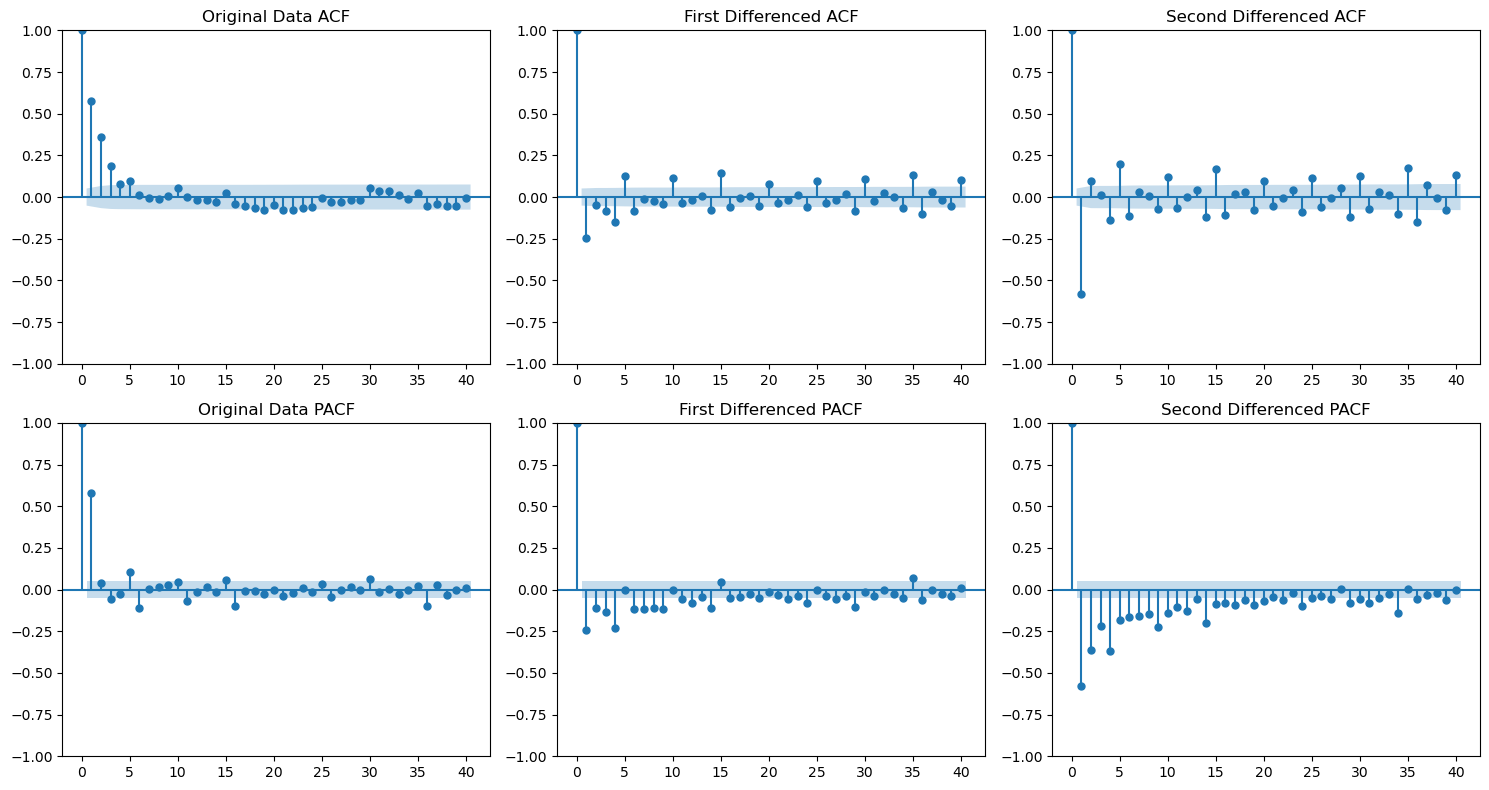

Augmented Dickey-Fuller Test with 0 differencing:
Test Statistic: -9.4121
p-value: 0.0000
Critical Values:
	1%: -3.4349
	5%: -2.8636
	10%: -2.5678
Reject the null hypothesis. The series is stationary.
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1452
Model:               SARIMAX(4, 0, 3)   Log Likelihood               -2793.857
Date:                Thu, 09 May 2024   AIC                           5605.714
Time:                        11:31:18   BIC                           5653.240
Sample:                             0   HQIC                          5623.448
                               - 1452                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept

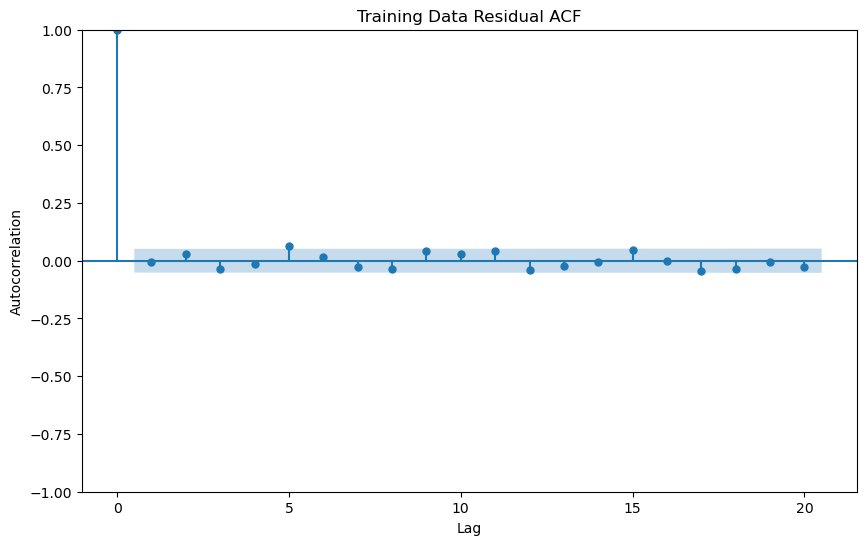

RMSE: 30.175
MAE: 18.910
MAPE: 20282762885437932.000%


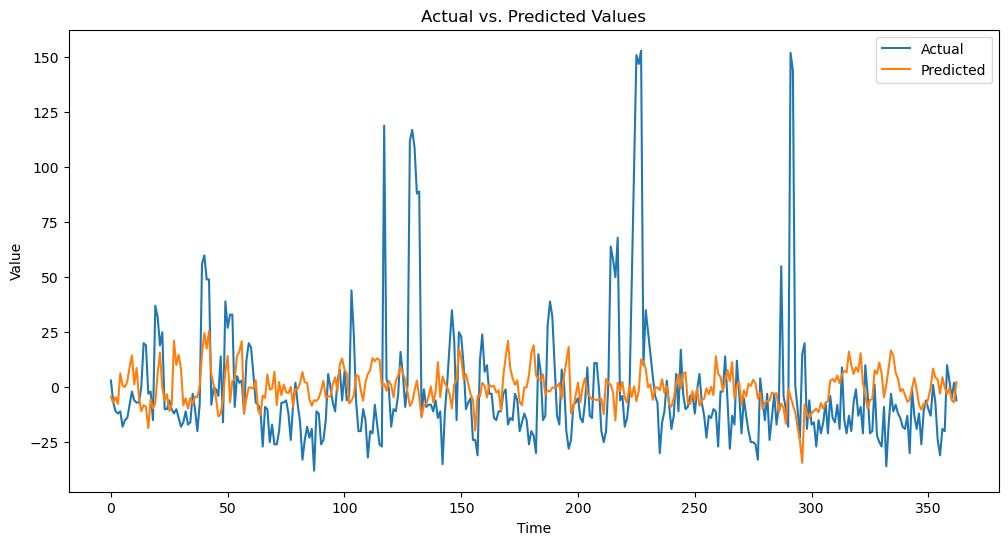

In [40]:
#build a Pipline
P = pipline(data.loc[data['FLIGHT_ID'] == 'AS64'],is_iqr=True,is_boxcox=True,train_ratio=0.8)
#You must call fit() beforehand
P.fit()
#You may want to check whether differencing order is appropriate by ACF/PACF or UnitSquar test
P.ACF()
P.UnitSquare(0) #order 0
# model summary(contatining 混成检验) and residual analysis
P.summary()
# prediction metrics
P.metrics()
# prediction plot
P.plot()